In [1]:
import tensorflow as tf
#from scipy.io import loadmat

In [1]:
import struct

import numpy as np

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    
train_set = read_idx('train-images-idx3-ubyte.mat')
print(train_set.shape)
train_label = read_idx('train-labels-idx1-ubyte.mat')
train_label = np.expand_dims(train_label, axis=1)
print(train_label.shape)

test_set = read_idx('t10k-images-idx3-ubyte.mat')
print(test_set.shape)
test_label = read_idx('t10k-labels-idx1-ubyte.mat')
test_label = np.expand_dims(test_label, axis=1)
print(test_label.shape)
n_train = train_set.shape[0]
n_test = test_set.shape[0]


C:\Users\User\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


(60000, 28, 28)
(60000, 1)
(10000, 28, 28)
(10000, 1)


In [3]:
def one_hot(labels):
    """
    Encodes the labels as one-hot vectors. Zero is represented as 10 in SVHN.
    [10] -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    [2] -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    
    """
    labels = np.squeeze(labels)
    one_hot_labels = []
    for num in labels:
        one_hot = [0.0] * 10
        if num == 10:
            one_hot[0] = 1.0
        else:
            one_hot[num] = 1.0
        one_hot_labels.append(one_hot)
    labels = np.array(one_hot_labels).astype(np.float32)
    return labels

In [4]:
train_label_one_hot = one_hot(train_label)
test_label_one_hot = one_hot(test_label)


print(train_label_one_hot.shape)
print(test_label_one_hot.shape)

(60000, 10)
(10000, 10)


In [6]:
class SVHN_MLP:
    def __init__(self, wd_factor, learning_rate):
        self.wd_factor = wd_factor
        self.learning_rate = learning_rate
        self.train_pointer = 0
        self.test_pointer = 0
        
        self.sess = tf.Session() #open session which need to be closed later
        
        self.input = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='input')
        self.ground_truth = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='ground_truth')
        print(self.input)
        
        self._build_graph()
        
    def _build_graph(self):
        weights = []  # for weight decay
        
        with tf.variable_scope('layers'):
            h = tf.layers.dense(self.input, 512, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='1')
            print(h)
            h = tf.layers.dense(h, 256, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='2')
            print(h)
            h = tf.layers.dense(h, 64, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='3')
            print(h)
            self.logits = tf.layers.dense(h, 10, kernel_initializer=tf.glorot_uniform_initializer(), 
                                          activation=tf.identity, name='4')
            print(self.logits)
            self.prediction = tf.nn.softmax(self.logits, name='softmax_prediction')
            
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, 
                                                                                  labels=self.ground_truth))
            self.loss += self.weight_decay()
            
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)
            
    def weight_decay(self):
        loss = 0
        for v in tf.global_variables():
            if 'Adam' in v.name:
                continue
            elif 'kernel' in v.name:
                loss += self.wd_factor * tf.nn.l2_loss(v)
        print(loss)
        return loss
    
    def train_minibatch(self, samples, labels, batch_size):
        if self.train_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.train_pointer: self.train_pointer + batch_size]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer += batch_size
        else:
            samples_minibatch = samples[self.train_pointer:]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer = 0
        return samples_minibatch, labels_minibatch

    def train(self, train_samples, train_labels, train_batch_size, iteration_steps):
        self.sess.run(tf.global_variables_initializer())

        print('Start Training')
        losses = []
        for i in range(iteration_steps):
            samples, labels = self.train_minibatch(train_samples, train_labels, train_batch_size)
            feed_dict = {self.input: samples, self.ground_truth: labels}
            _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)
            if i % 50 == 0:
                print("Minibatch loss at step {}: {}".format(i, loss))
                losses.append([i, loss])
        return losses
                    
    def test_minibatch(self, samples, labels, batch_size):
        if self.test_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.test_pointer: self.test_pointer + batch_size]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer += batch_size
            end_of_epoch = False
        else:
            samples_minibatch = samples[self.test_pointer:]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer = 0
            end_of_epoch = True
        return samples_minibatch, labels_minibatch, end_of_epoch
            
    def test(self, test_samples, test_labels, test_batch_size):
        end_of_epoch = False
        losses = []
        while not end_of_epoch:
            samples, labels, end_of_epoch = self.test_minibatch(test_samples, test_labels, test_batch_size)
            feed_dict = {self.input: samples, self.ground_truth: labels}
            losses.append(self.sess.run(self.loss, feed_dict=feed_dict))  
        print("Average test loss: {}".format(np.mean(losses)))

In [7]:
WD_FACTOR = 0.0001
LEARNING_RATE = 0.001
model = SVHN_MLP(WD_FACTOR, LEARNING_RATE)

Tensor("input:0", shape=(?, 784), dtype=float32)
Tensor("layers/1/Tanh:0", shape=(?, 512), dtype=float32)
Tensor("layers/2/Tanh:0", shape=(?, 256), dtype=float32)
Tensor("layers/3/Tanh:0", shape=(?, 64), dtype=float32)
Tensor("layers/4/Identity:0", shape=(?, 10), dtype=float32)
Tensor("loss/add_3:0", shape=(), dtype=float32)


In [8]:
tf.global_variables()

[<tf.Variable 'layers/1/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/2/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'layers/2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'layers/3/kernel:0' shape=(256, 64) dtype=float32_ref>,
 <tf.Variable 'layers/3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/4/kernel:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'layers/4/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'layers/1/kernel/Adam:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/kernel/Adam_1:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias/Adam:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias/Adam_1:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/2/kernel/Adam:0' shape=(5

In [9]:
TRAIN_BATCH_SIZE = 128
ITERATIONS = 10000

import time
start_time = time.time()

losses = model.train(train_set_flat, train_label_one_hot, TRAIN_BATCH_SIZE, ITERATIONS)

end_time = time.time()
print("Training time: {}s".format(end_time - start_time))

Start Training
Minibatch loss at step 0: 2.702282667160034
Minibatch loss at step 50: 0.44658398628234863
Minibatch loss at step 100: 0.4284670650959015
Minibatch loss at step 150: 0.35804522037506104
Minibatch loss at step 200: 0.3786954879760742
Minibatch loss at step 250: 0.4471348524093628
Minibatch loss at step 300: 0.3881988227367401
Minibatch loss at step 350: 0.48940616846084595
Minibatch loss at step 400: 0.5326048135757446
Minibatch loss at step 450: 0.4276096522808075
Minibatch loss at step 500: 0.37688133120536804
Minibatch loss at step 550: 0.2934891879558563
Minibatch loss at step 600: 0.3498244285583496
Minibatch loss at step 650: 0.2897154986858368
Minibatch loss at step 700: 0.3381035625934601
Minibatch loss at step 750: 0.35911548137664795
Minibatch loss at step 800: 0.48753461241722107
Minibatch loss at step 850: 0.2186792939901352
Minibatch loss at step 900: 0.43422621488571167
Minibatch loss at step 950: 0.294033408164978
Minibatch loss at step 1000: 0.359914243221

Minibatch loss at step 8450: 0.4191369116306305
Minibatch loss at step 8500: 0.3971833288669586
Minibatch loss at step 8550: 0.2810768783092499
Minibatch loss at step 8600: 0.2499244213104248
Minibatch loss at step 8650: 0.5365243554115295
Minibatch loss at step 8700: 0.24666738510131836
Minibatch loss at step 8750: 0.23073720932006836
Minibatch loss at step 8800: 0.3109894096851349
Minibatch loss at step 8850: 0.23334896564483643
Minibatch loss at step 8900: 0.21024471521377563
Minibatch loss at step 8950: 0.19578462839126587
Minibatch loss at step 9000: 0.23969770967960358
Minibatch loss at step 9050: 0.2628476321697235
Minibatch loss at step 9100: 0.37376469373703003
Minibatch loss at step 9150: 0.266936719417572
Minibatch loss at step 9200: 0.3849117159843445
Minibatch loss at step 9250: 0.19202613830566406
Minibatch loss at step 9300: 0.26308703422546387
Minibatch loss at step 9350: 0.29862749576568604
Minibatch loss at step 9400: 0.2153506875038147
Minibatch loss at step 9450: 0.

In [10]:
losses = np.array(losses)
print(losses.shape)

(200, 2)


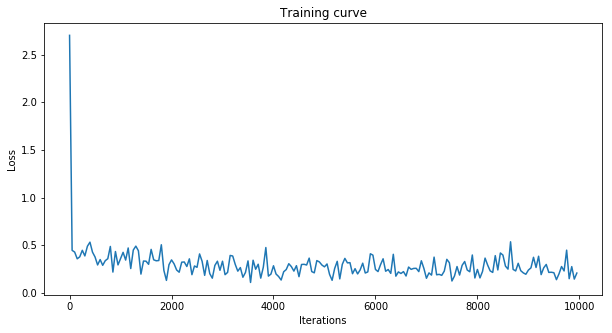

In [12]:
import matplotlib.pyplot as plt

iterations = losses[:, 0]
train_loss = losses[:, 1]
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training curve")
plt.show()

In [13]:
TEST_BATCH_SIZE = 128

model.test(test_set_flat, test_label_one_hot, TEST_BATCH_SIZE)

Average test loss: 0.24835851788520813


Test sample digit: 4


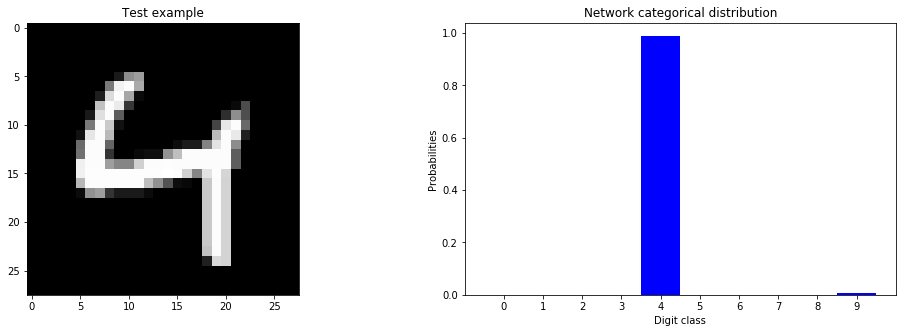

Network prediction probabilities:
[5.3111033e-04 1.3125176e-06 4.5174954e-04 4.0939463e-05 9.8924023e-01
 9.5570147e-05 9.4148330e-04 6.7149711e-05 2.0632856e-04 8.4240958e-03]


In [43]:
example = np.random.choice(np.arange(n_test))

sample = np.expand_dims(test_set_flat[example], axis=0)
label = np.expand_dims(test_label_one_hot[example], axis=0)

digit = np.where(label[0]==1.0)[0][0]

feed_dict = {model.input: sample, model.ground_truth: label}
prediction = model.sess.run(model.prediction, feed_dict=feed_dict)[0]

image = np.reshape(sample, (28, 28))

print("Test sample digit: {}".format(digit))
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Test example")

classes = np.arange(10)
width = 1.0

#fig, ax = plt.subplots()
ax[1].bar(classes, prediction, width, color='Blue')
ax[1].set_ylabel('Probabilities')
ax[1].set_title('Network categorical distribution')
ax[1].set_xticks(classes)
ax[1].set_xticklabels(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
ax[1].set_xlabel('Digit class')

plt.show()

print("Network prediction probabilities:")
print(prediction)

In [2]:
train_time = end_time - start_time
print('total training time :', train_time, 's, or ', int(train_time/60), 'min', train_time%60, 's' )
count = len(tf.global_variables())
print('total parameters involved :', count)

NameError: name 'end_time' is not defined

In [ ]:
model.sess.close()